In [1]:
import geoopt
import torch
import numpy as np
import random
import logging
import json

In [2]:
weights = np.load("../models/hyperbolic/weights.npy")
song2ids = json.load(open("../models/hyperbolic/song2idx.json"))

In [2]:
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.pca import TangentPCA
from geomstats.geometry.hyperboloid import Hyperboloid

INFO: Using numpy backend


In [4]:
manifold = Hyperboloid(dim=weights.shape[1]-1)

In [6]:
mean = FrechetMean(metric=manifold.metric)
mean.fit(weights)

FrechetMean(metric=<geomstats.geometry.hyperboloid.HyperboloidMetric object at 0x7ff6ea5a9510>,
            point_type='vector')

In [7]:
tpca = TangentPCA(metric=manifold.metric, n_components=2)
tpca.fit(weights, base_point=mean.estimate_)
projected = tpca.transform(weights)

In [8]:
distances = manifold.metric.dist(mean.estimate_, weights)

Text(0, 0.5, 'Log frequency of item')

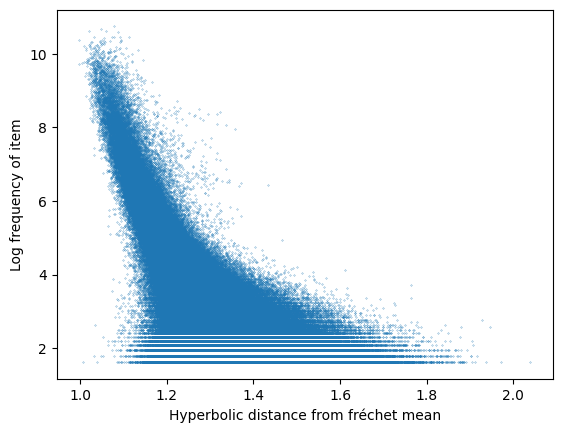

In [10]:
import matplotlib.pyplot as plt
freqs = json.load(open("../data/frequencies.json"))
colors = np.log([freqs[id_] for id_ in song2ids.keys()])
plt.scatter(distances, colors, s=0.05)
plt.xlabel("Hyperbolic distance from fréchet mean")
plt.ylabel("Log frequency of item")

In [3]:
from sklearn.neighbors import NearestNeighbors

class LorentzInnerProductNearestNeighbors:
    
    def __init__(self, manifold, k):
        self.k = k
        self.manifold = manifold
        
    def fit(self, x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x)
        self.x = x
        self.x0 = torch.zeros(x.shape[1]).to(x.device)
        
    @torch.no_grad()
    def _scores(self, x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x)
        if len(x.shape) > 1:
            return torch.stack([self.manifold.inner(self.x0, self.x, xi) for xi in x], dim=0)
        return self.manifold.inner(self.x0, self.x, x)
    
    def kneighbors(self, x, return_distance=True, include_self=False):
        scores = self._scores(x)
        order = np.argsort(-scores, axis=-1)
        offset, k = 0 if include_self else 1, self.k if include_self else self.k+1
        if return_distance:
            return -scores[order], order[:, offset:k]
        return order[:, offset:k].cpu().numpy()
    


In [23]:
from collections import Counter

class Recommender:
    
    def __init__(self, song2ids, knn, vecs):
        self.song2ids = song2ids
        self.ids2song = {v:k for k,v in song2ids.items()}
        self.known_songs = set(song2ids.keys())
        self._vecs = vecs
        self.knn = knn
        self.knn.fit(vecs)
        
    def recommend(self, songs, k=500):
        assert isinstance(songs, list), "Must provide list!"
        songs = list(filter(lambda song: song in self.known_songs, songs))
        ids = [self.song2ids[song] for song in songs]
        vecs = self._vecs[ids]
        nns = self.knn.kneighbors(vecs, return_distance=False)
        recommendations = [[self.ids2song[neighbor] for neighbor in song_neighbors] for song_neighbors in nns]
        c = Counter(reduce(list.__add__, recommendations))
        return [song for song,_ in c.most_common(k)]

In [5]:
import sys
sys.path.insert(0, "../src/")
from models.transformer.loader import PlaylistDataset
from models.transformer.transform import *

In [6]:
import os

# utils to create this file list

def get_file_list(base):
    return [os.path.join(base, f) for f in os.listdir(base) if ".json" in f]

files = get_file_list("../data/processed/")
len(files)

20

In [189]:
dataset = PlaylistDataset(files, 50_000)

#knn = LorentzInnerProductNearestNeighbors(geoopt.manifolds.Lorentz(1, learnable=False), 50)
knn = NearestNeighbors(n_neighbors=50, metric="cosine")
r = Recommender(song2ids, knn, weights)

In [190]:
from functools import reduce

for playlist in dataset:
    split = min(15, len(playlist) // 2)
    part1, part2 = playlist[:split], set(playlist[split:])
    recs = set(reduce(list.__add__, r.recommend(part1)))
    hits = len(recs & part2)
    hr = hits / split
    print(hr)

0.06666666666666667
0.0
0.2
0.0
0.0
0.0
0.3333333333333333
0.13333333333333333
0.0
0.0
0.2
0.06666666666666667
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0



KeyboardInterrupt



In [100]:
l = list(range(10))
split = 5
l[:split], l[split:]

([0, 1, 2, 3, 4], [5, 6, 7, 8, 9])

In [13]:
from gensim.models import Word2Vec

wv = Word2Vec.load("../models/s2v_large/s2v_large").wv
weights = wv.vectors
song2ids = wv.key_to_index

INFO: loading Word2Vec object from ../models/s2v_large/s2v_large
INFO: loading wv recursively from ../models/s2v_large/s2v_large.wv.* with mmap=None
INFO: loading vectors from ../models/s2v_large/s2v_large.wv.vectors.npy with mmap=None
INFO: loading syn1neg from ../models/s2v_large/s2v_large.syn1neg.npy with mmap=None
INFO: setting ignored attribute cum_table to None
INFO: Word2Vec lifecycle event {'fname': '../models/s2v_large/s2v_large', 'datetime': '2023-05-11T16:42:47.366808', 'gensim': '4.3.1', 'python': '3.10.6 (main, Mar 10 2023, 10:55:28) [GCC 11.3.0]', 'platform': 'Linux-5.19.0-41-generic-x86_64-with-glibc2.35', 'event': 'loaded'}


In [24]:
dataset = PlaylistDataset(files, 50_000)

#knn = LorentzInnerProductNearestNeighbors(geoopt.manifolds.Lorentz(1, learnable=False), 50)
knn = NearestNeighbors(n_neighbors=50, metric="cosine")
r = Recommender(song2ids, knn, weights)

In [29]:
from functools import reduce

for playlist in dataset:
    split = min(15, len(playlist) // 2)
    part1, part2 = playlist[:split], set(playlist[split:])
    recs = set(r.recommend(part1, k=500))
    hits = len(recs & part2)
    hr = hits / split
    print(hits)

29
15
3
6
2
1
15
45
35
13
2
31
3
0
9
1
31


KeyboardInterrupt: 